<a href="https://colab.research.google.com/github/uzair011/CN6022/blob/main/churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import kagglehub

# Download latest version
data = kagglehub.dataset_download("sameerhussain007/subscription-churn-dataset")

print("Path to dataset files:", data)

Path to dataset files: /kaggle/input/subscription-churn-dataset


In [27]:
import os
print(os.listdir(data))

['Subscription_Service_Churn_Dataset.csv']


# Data Preprocessing

In [28]:
import pandas as pd

# Adjust this filename based on the output from os.listdir(data)
file_path = os.path.join(data, "Subscription_Service_Churn_Dataset.csv")

# Read
df = pd.read_csv(file_path)
print(df.head())


   AccountAge  MonthlyCharges  TotalCharges SubscriptionType  \
0          42       11.321950    475.521914            Basic   
1          95       12.810915   1217.036887         Standard   
2           6             NaN     91.583304         Standard   
3          54       17.917819    967.562224            Basic   
4          27             NaN    339.057244            Basic   

      PaymentMethod PaperlessBilling ContentType MultiDeviceAccess  \
0  Electronic check              Yes      Movies               Yes   
1  Electronic check              Yes    TV Shows                No   
2       Credit card              Yes    TV Shows                No   
3               NaN              Yes      Movies                No   
4      Mailed check               No    TV Shows                No   

  DeviceRegistered  ViewingHoursPerWeek  ...  ContentDownloadsPerMonth  \
0           Tablet             0.386852  ...                        25   
1           Mobile            37.123000  ...  

In [29]:
df = df.drop(columns=['CustomerID'])

In [30]:
# Check for missing values
print(df.info(), "\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963 entries, 0 to 962
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   AccountAge                963 non-null    int64  
 1   MonthlyCharges            759 non-null    float64
 2   TotalCharges              777 non-null    float64
 3   SubscriptionType          913 non-null    object 
 4   PaymentMethod             740 non-null    object 
 5   PaperlessBilling          963 non-null    object 
 6   ContentType               963 non-null    object 
 7   MultiDeviceAccess         963 non-null    object 
 8   DeviceRegistered          887 non-null    object 
 9   ViewingHoursPerWeek       963 non-null    float64
 10  AverageViewingDuration    963 non-null    float64
 11  ContentDownloadsPerMonth  963 non-null    int64  
 12  GenrePreference           853 non-null    object 
 13  UserRating                702 non-null    float64
 14  SupportTic

According to this,
- `TotalCharges` and
 `UserRating` contains numaircal null values.

-  `SubscriptionType`, `PaymentMethod`, ` DeviceRegistered`, `GenrePreference`, `Gender`and `SubtitlesEnabled` contains categorical null values.

In [31]:
## Handling missing data

# Missing numarical columns with median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df['UserRating'] = df['UserRating'].fillna(df['UserRating'].median())

In [32]:
# 1
# categorical_cols_to_fix = ['SubscriptionType', 'PaymentMethod', 'DeviceRegistered',
#                            'GenrePreference', 'Gender', 'SubtitlesEnabled']

# # Fill missing values for categorical columns
# for col in categorical_cols_to_fix:
#     if col in df.columns:
#         if not df[col].mode().empty:
#             df[col] = df[col].fillna(df[col].mode()[0])
#         else:
#             print(f"Mode not found for column '{col}', possibly all NaN values.")
#     else:
#         print(f"Column '{col}' not found in the DataFrame.")

# # Only pass existing columns to pd.get_dummies
# valid_categorical_cols = [col for col in categorical_cols_to_fix if col in df.columns]
# df = pd.get_dummies(df, columns=valid_categorical_cols)

# print("All done, fixed and encoded!")


In [33]:
categorical_cols_to_fix = [
    'SubscriptionType', 'PaymentMethod', 'DeviceRegistered',
    'GenrePreference', 'Gender', 'SubtitlesEnabled',
    'PaperlessBilling', 'ContentType', 'MultiDeviceAccess', 'ParentalControl'
]

for col in categorical_cols_to_fix:
    if col in df.columns:
        mode_val = df[col].mode()[0] if not df[col].mode().empty else None
        if mode_val is not None:
            df[col] = df[col].fillna(mode_val)
        else:
            print(f"Column '{col}' has no non-NaN mode.")
    else:
        print(f"Column '{col}' not found in DataFrame.")

In [34]:
#df = pd.get_dummies(df, columns=categorical_cols_to_fix)

In [35]:
# scale numarical values by normaliseing
from sklearn.preprocessing import StandardScaler

numerical_cols = [
    'AccountAge', 'MonthlyCharges', 'TotalCharges',
    'ViewingHoursPerWeek', 'AverageViewingDuration',
    'ContentDownloadsPerMonth', 'UserRating',
    'SupportTicketsPerMonth', 'WatchlistSize'
]

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Split,Training, ...

1. SPLIT THE DATA

In [36]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Churn'])  # features
y = df['Churn']  # Target column

# Split into 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 770, Testing samples: 193


2. CONVERT DATA -> PYTORCH TENSORS

In [37]:
# # 11
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# import numpy as np
# import pandas as pd

# # Convert NumPy arrays to PyTorch tensors
# for col in X_train.select_dtypes(include=['object']).columns:
#     X_train[col], _ = pd.factorize(X_train[col]) #'object' type columns to numerical using pandas.factorize()
#     X_test[col], _ = pd.factorize(X_test[col])

# # Convert NumPy arrays to PyTorch tensors
# X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1)
# X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1)

# # Create PyTorch Datasets & DataLoaders
# ## TensorDataset: group togethor tensors to treat it as a one dataset.
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# ## DataLoader: makes it easy to iterate over datasets in batches.
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# print("Data successfully converted to PyTorch tensors!")

In [38]:
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# A bit of data cleaning and preprocessing
# Replace infinite values with a large finite value
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_train = X_train.fillna(X_train.max())

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = X_test.fillna(X_test.max())

# Convert 'object' type columns to numerical using pandas.factorize()
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col], _ = pd.factorize(X_train[col])
    X_test[col], _ = pd.factorize(X_test[col])

X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.astype(np.float32), dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
## DataLoader: makes it easy to iterate over datasets in batches.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Data successfully converted to PyTorch tensors!")

Data successfully converted to PyTorch tensors!


3. A simple neural Network

In [39]:
import torch.nn as nn

# define the model
class ChurnNN(nn.Module):
    def __init__(self, input_size):
        super(ChurnNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

        # Initialize weights using Xavier initialization for better stability
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialise the model
input_size = X_train.shape[1]  # Number of features
model = ChurnNN(input_size)

print(model)


ChurnNN(
  (fc1): Linear(in_features=19, out_features=16, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


4. TRAIN THE MODEL

In [40]:
import torch.optim as optim

# Loss Function and Optimiser
criterion = nn.BCEWithLogitsLoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:

      # Check for NaN or infinite values in input data
        if torch.isnan(X_batch).any() or torch.isinf(X_batch).any():
            print("NaN or infinite values found in input data. Skipping batch.")
            continue

        optimizer.zero_grad()  # Clear gradients
        y_pred = model(X_batch)  # Forward pass
        loss = criterion(y_pred, y_batch)  # Compute loss

        if torch.isnan(loss): #        # Check for NaN loss and skip backward pass if found
            print(f"NaN loss encountered at epoch {epoch}.")
            continue

        loss.backward()  # Back propagation
        #gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()  # Update weights
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
      avg_loss = total_loss / len(train_loader)
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [10/100], Loss: 0.4172
Epoch [20/100], Loss: 0.4267
Epoch [30/100], Loss: 0.4261
Epoch [40/100], Loss: 0.3689
Epoch [50/100], Loss: 0.3951
Epoch [60/100], Loss: 0.3544
Epoch [70/100], Loss: 0.3495
Epoch [80/100], Loss: 0.3551
Epoch [90/100], Loss: 0.3375
Epoch [100/100], Loss: 0.3323


## VISUALISATION

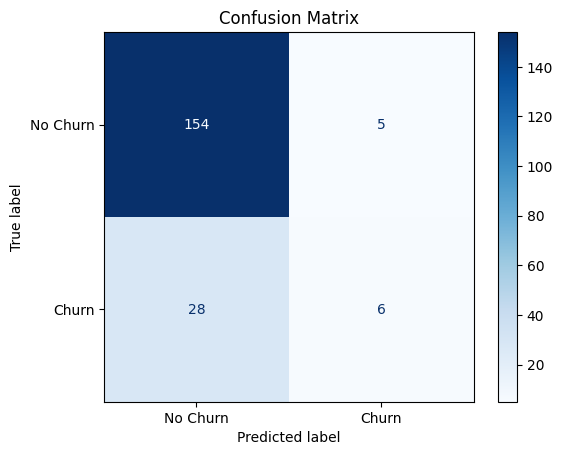

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch


model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()

cm = confusion_matrix(y_test, y_pred_class)
disp = ConfusionMatrixDisplay(cm, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

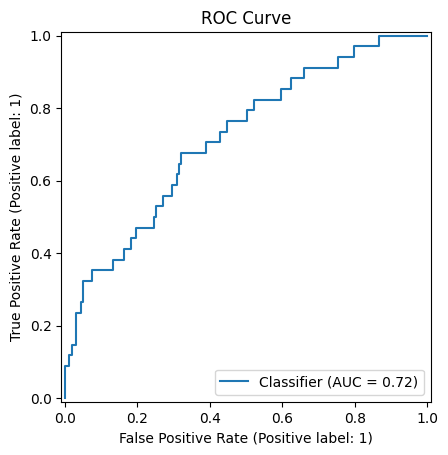

In [44]:
from sklearn.metrics import RocCurveDisplay

y_pred_proba = torch.sigmoid(y_pred).numpy()
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('ROC Curve')
plt.savefig('roc_curve.png', dpi=300)
plt.show()